#Goal

This project uses GLMs to predict the selling price for homes listed for sale in Ames, Iowa. Since there are 80 initial features in the dataset extensive data cleaning is needed to ensure accuracy, along with strong feature engineering. Then to generate predictions, OLS with cross validation will be used as the baseline model before using Lasso with cross validation, with RMSE as the evaluation criteria.

#Data Loading

In [553]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [554]:
#reading data into python from github
url = 'https://raw.githubusercontent.com/bmaddry/housing_prices/refs/heads/main/housing_prices.csv'
df = pd.read_csv(url, index_col=0)

#examining the first few rows of data
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [555]:
#looking at the data types for feature variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallCond  

In [556]:
#checking the shape of the raw dataset
df.shape

(1460, 81)

#Data Cleaning

In [557]:
#checking for null values
null = df.isnull().sum() > 0

#displaying features that contain null values
df.isnull().sum()[null]

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [558]:
#creating a list of column names with null values to view the columns
null_columns = df.isnull().sum()[null].index

#previewing the null column data
df[null_columns].head(5)

,LotFrontage,Alley,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,BrkFace,196.0,Gd,TA,No,GLQ,Unf,SBrkr,NaN,Attchd,2003.0,RFn,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,0.0,Gd,TA,Gd,ALQ,Unf,SBrkr,TA,Attchd,1976.0,RFn,TA,TA,NaN,NaN,NaN
2,68.0,NaN,BrkFace,162.0,Gd,TA,Mn,GLQ,Unf,SBrkr,TA,Attchd,2001.0,RFn,TA,TA,NaN,NaN,NaN
3,60.0,NaN,NaN,0.0,TA,Gd,No,ALQ,Unf,SBrkr,Gd,Detchd,1998.0,Unf,TA,TA,NaN,NaN,NaN
4,84.0,NaN,BrkFace,350.0,Gd,TA,Av,GLQ,Unf,SBrkr,TA,Attchd,2000.0,RFn,TA,TA,NaN,NaN,NaN


So null values, are going to be a problem. Since this is a relatively small dataset (1,460 data points), the following will be used to fix:

*   Drop columns that are filled with mostly null values
*   Fill out categorical value columns with 'NA', since dummies will be created
*   Set the 'GarageYrBlt', to be equal to the year the home was built
*   Fill the 'MaxVnrArea' nulls with 0, since this column contains several 0 values already
*   Use a median value for lot frontage, as a 0 for this feature is unrealistic (it references the length of the street in front of the property)





In [559]:
#dropping columns that are predominently made up of null values
df = df.drop(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [560]:
#listing categorical columns with null values
cat_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

#filling the categorical columns with NA
df[cat_cols] = df[cat_cols].fillna('NA')

In [561]:
#setting the garage year built value, to be equal to the year the home was built
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

#filling the MaxVnrArea null values with a 0
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

#inputting the median value, for the lot frontage nulls
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

In [562]:
#checking to ensure all of the null values were filled
df.isnull().sum()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [563]:
#checking for duplicate values in the dataset
duplicates = df.duplicated().sum()
print(f'Duplicate values in the dataset: {duplicates}')

Duplicate values in the dataset: 0


In [564]:
#seperating features and the target variable to create dummies
factors = list(df.select_dtypes(include=['object']).columns)
numerics = list(df.select_dtypes(include=['float64', 'int64']).columns)
df_factors = df[factors]
df_numerics = df[numerics]
dummies = pd.get_dummies(df_factors.astype('object'), drop_first=True, dtype=int)
df = pd.concat([df_numerics, dummies], axis=1)

In [565]:
#previewing the data to ensure the dummies were coded correctly
df.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,1,0,0,0,1,0


In [566]:
#looking at the new size of the dataset -- there are now 246 features, including the target
df.shape

(1460, 246)

#Exploratory Data Analysis and Feature Engineering

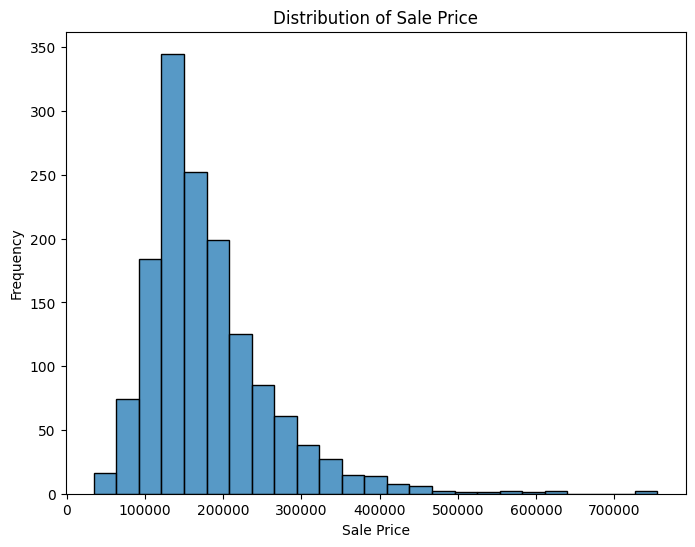

In [567]:
#looking at the distribution of the target variable, sale price
plt.figure(figsize=(8, 6))
sns.histplot(df['SalePrice'], bins=25)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

So, there's a fairly normal distribution of the target variable, although there is a right skewed tail. It might be best to transform Sale Price into a log to account for the tail, after feature engineering.

When creating features, any variables used that result in a perfect linear relationship will be dropped, to prevent multicolinearity.

In [568]:
#creating a variable, that looks at total square feet of the home
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df = df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1)

In [569]:
#similarily, creating a feature that accounts for total porch square feet
df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df = df.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

In [570]:
#making a new feature, that shows the years since a house has been remodeled
df['YrsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
df = df.drop('YearRemodAdd', axis=1)

In [571]:
#making a feature for house age
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df = df.drop(['YrSold', 'YearBuilt'], axis=1)

In [572]:
#creating a feature for total bathrooms
df['TotalBath'] = df['FullBath'] + df['HalfBath']*0.5 + df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

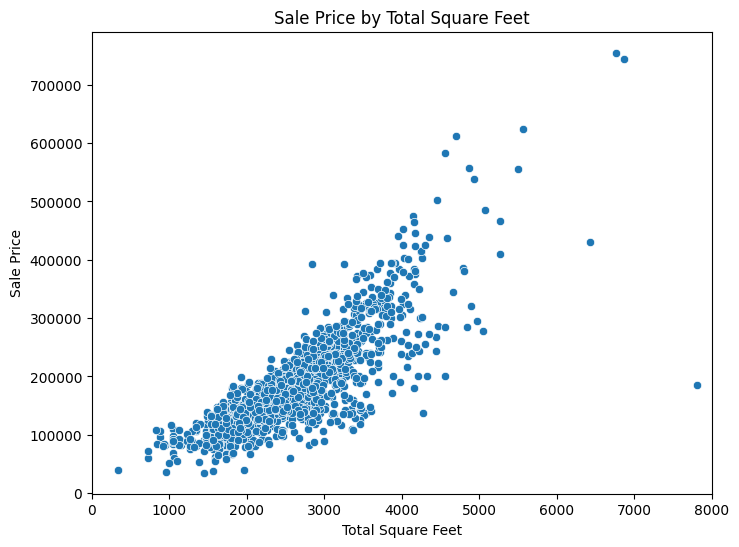

In [573]:
#visualizing the relatinship between sale price, and total square feet (one of the engineered features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'TotalSF', y = 'SalePrice', data = df)
plt.title('Sale Price by Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Sale Price')
plt.xlim(0, 8000)
plt.show()

In [574]:
#since sqft is a strong predictor, a non-linear relationship could help with the models predicting power
df['SFsq'] = df['TotalSF'] ** 2

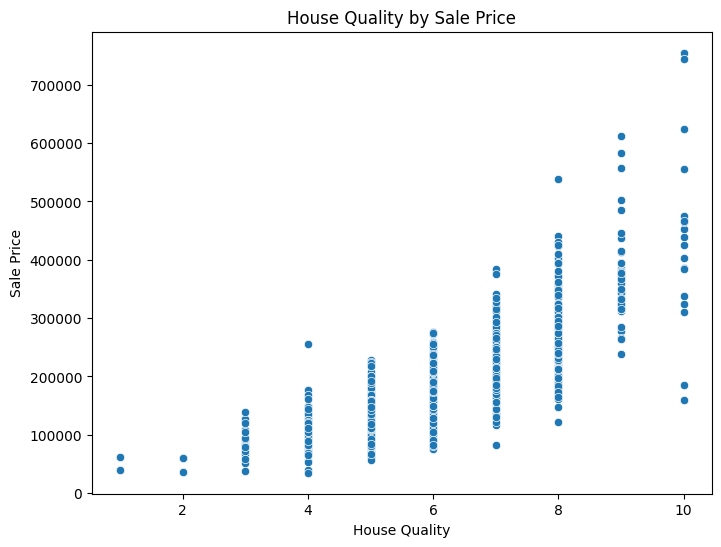

In [575]:
#looking at the correlation between quality and sale price
plt.figure(figsize=(8,6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.xlabel('House Quality')
plt.ylabel('Sale Price')
plt.title('House Quality by Sale Price')
plt.show()

In [576]:
#since house quality is strongly correlated with sale price, an interaction term with house condition should add to the models predictive power
df['OverallQualCond'] = df['OverallQual'] * df['OverallCond']

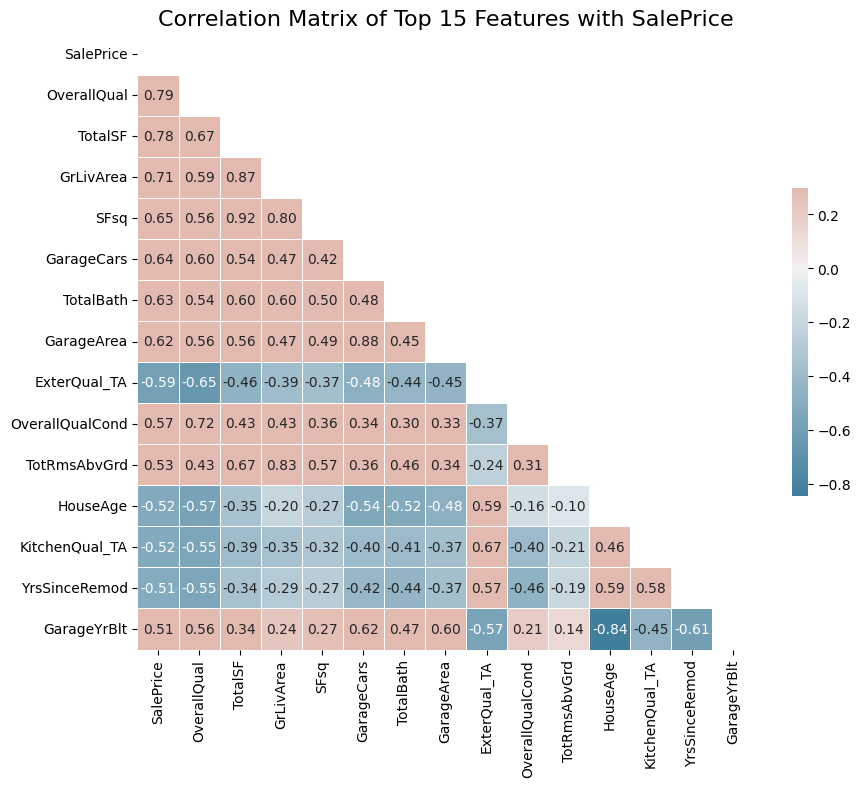

In [577]:
#seeing how correlated features are, with the target variable
corr = df.corr(numeric_only=True)['SalePrice'].abs().sort_values(ascending=False)

#grabbing just the top 15 most correlated features and creating a dataframe, to avoid listing every column
top_15_features = corr.head(15).index.tolist()
df_top_15 = df[top_15_features]

#creating a correlation matrix
corr_matrix = df_top_15.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#displaying the correlation matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Top 15 Features with SalePrice', fontsize=16)
plt.show()

So, it looks like engineered features introduced some strong correlation trends with Sale Price -- specifically within the terms of Total Square Feet, Total Bathrooms, House Age, and Years Since Remodeled.

There's also value added from the Quality and Condition interaction term, and by squaring Total Square Feet. This should introduce non-linearity, to increase the model's predictive power.

Finally before running the GLMs, scaling and train-test-split need to be run.

In [578]:
#defining X and y, along with initializing the StandardScaler
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

#transforming sale price to be a log
y = np.log1p(y)

In [579]:
#initializing the scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = sm.add_constant(X)

#running train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

#OLS

In [580]:
#initializing ols regression
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [581]:
#running ols with cross validation
rmse_ols_cv = -cross_val_score(ols, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Cross-Validation RMSE scores:", rmse_ols_cv)
print("Average cross-validation RMSE:", rmse_ols_cv.mean())

Cross-Validation RMSE scores: [0.11556573 0.17561519 0.13457686 0.13355823 0.20380686]
Average cross-validation RMSE: 0.15262457540172436


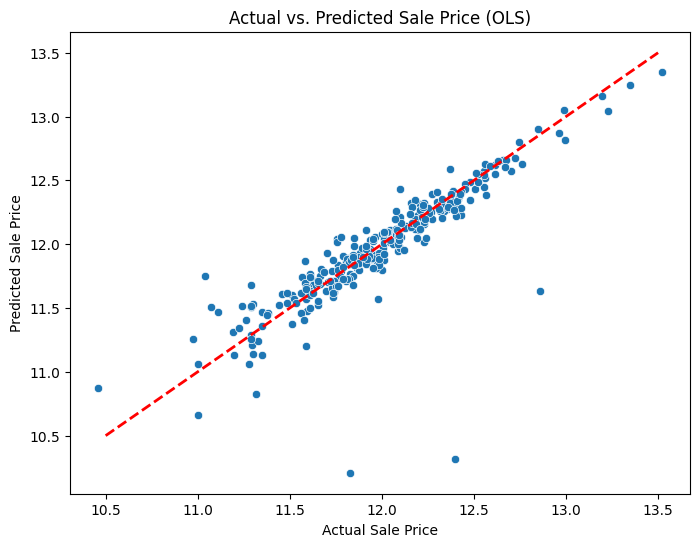

In [582]:
#visualizing the ols results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_ols)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price (OLS)')
plt.plot([10.5, 13.5], [10.5, 13.5], 'r--', linewidth=2)
plt.show()

Overall, the initial model is fairly accurate with an RMSE of 0.15. There's a couple of outliers that it's struggling to place, but most of the predictions are clustered around the dotted red line.

#Lasso

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-4089544237.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Alpha ($\lambda$)')


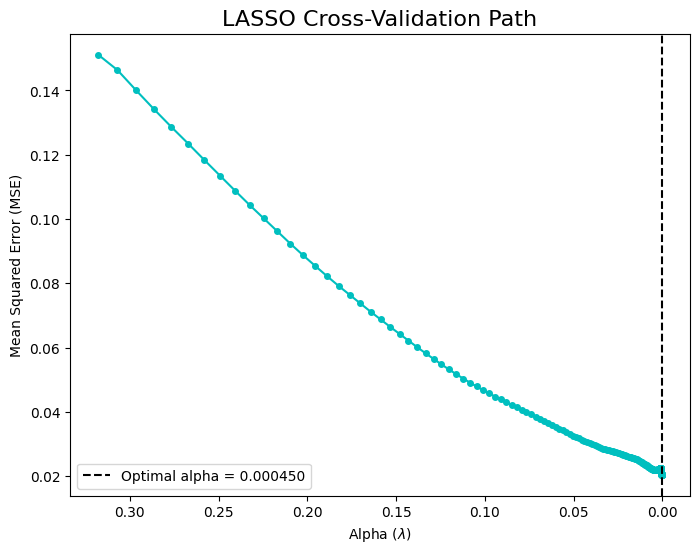

In [583]:
#initializing lasso with cross validation
lasso_cv = LassoCV(n_alphas=200, cv=5, random_state=24, n_jobs=-1, max_iter=10000)
lasso_cv.fit(X_train, y_train)

#finding the mse for each alpha
mean_mse_path = np.mean(lasso_cv.mse_path_, axis=1)

#plotting the relationship between each alpha and mse
plt.figure(figsize=(8, 6))
plt.plot(lasso_cv.alphas_, mean_mse_path, marker='o', linestyle='-', markersize=4, color='c')
plt.axvline(lasso_cv.alpha_, linestyle='--', color='k', label=f'Optimal alpha = {lasso_cv.alpha_:.6f}')
plt.legend()
plt.xlabel('Alpha ($\lambda$)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('LASSO Cross-Validation Path', fontsize=16)
plt.gca().invert_xaxis()
plt.show()

It looks like for this model a very small Alpha will result in the best MSE. This will result in minimal regularization, and a small penalty for using a large amount of features.

In [584]:
#making predictions from the lasso model
y_pred_lasso_cv = lasso_cv.predict(X_test)

#calculating rmse
rmse_lasso_cv = (mean_squared_error(y_test, y_pred_lasso_cv))**.5
print(f"LassoCV Model Test Set RMSE: {rmse_lasso_cv:.4f}")

#analyzing the number of selected features
n_total_features = X_train.shape[1] - 1 # excluding the constant term
n_selected_features = np.sum(lasso_cv.coef_[1:] != 0)
print(f"\nTotal features available: {n_total_features}")
print(f"Features selected by LASSO (coefficients != 0): {n_selected_features}")

LassoCV Model Test Set RMSE: 0.1336

Total features available: 237
Features selected by LASSO (coefficients != 0): 200


In [585]:
#comparing the ols performance to lasso's
comparison_df = pd.DataFrame({
    'Model': ['OLS', 'Lasso'],
    'Number of Features': [X.shape[1], n_selected_features],
    'RMSE Score': [rmse_ols_cv.mean().round(2), round(rmse_lasso_cv,2)],
})

print("### Model Comparison ###")
print("------------------------")
comparison_df

### Model Comparison ###
------------------------


,Model,Number of Features,RMSE Score
0,OLS,238,0.15
1,Lasso,200,0.13


So, even though Lasso still used the majority of features available, there was a .02 RMSE improvement which increased accuracy by 13%. Below, Lasso's predictions are also visualized to compare with the original OLS model predictions previously displayed.

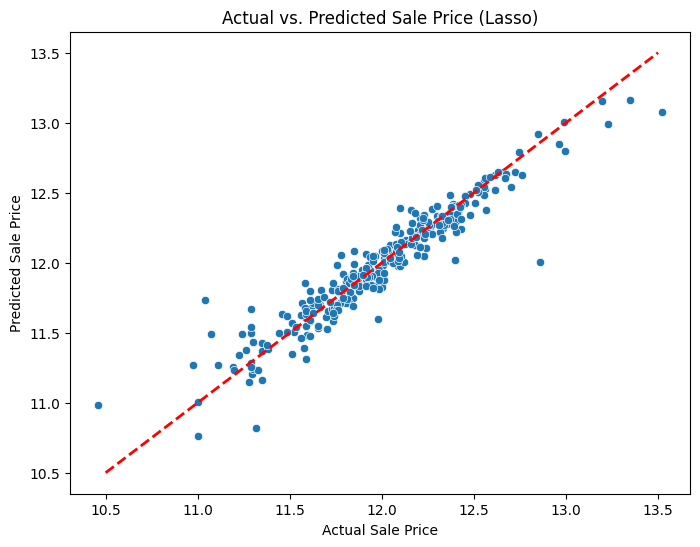

In [586]:
#visualizing the lasso results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lasso_cv)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price (Lasso)')
plt.plot([10.5, 13.5], [10.5, 13.5], 'r--', linewidth=2)
plt.show()

It looks like Lasso handled the outliers much better than OLS, as there aren't any data points floating in the bottom-right area.

However, the prediction power for lower sale price houses could still be improved. A next step could be taking the learnings from these GLM's, and seeing if Machine Learning techniques increase accuracy for these homes.